## Data Reading and Preprocessing

### Importing Neccesary Libraries

In [391]:
import PyPDF2
import re,os
import pandas as pd
import numpy as np
from tika import parser
from pprint import pprint
from datetime import datetime
import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from nltk import sent_tokenize,word_tokenize
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from gensim import models, corpora
import pyLDAvis.gensim as gensimvis
import pyLDAvis
from vaderSentiment import vaderSentiment as vader 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

In [2]:
cd

C:\Users\91907


### Mentioning the Path for the PDF files

In [3]:
speech_path = 'C:/Users/91907/Praxis/text Analytics/Obama speeches pdf/'

### Using ListDir to read all the FIles in the path


In [39]:
files = os.listdir(speech_path)

In [40]:
files.sort()

##### Note : I have used Tika instead of Py2PDF to extract the PDF text. Py2PDF was giving special characters instead of text, that may be because of these pdfs are done using Speech to Text method. To Run this Code Java 8.0 is required in the system.

In [107]:
speech = {'date':[],'heading':[],'content':[]}
for file in files:
    f = parser.from_file(speech_path+file)['content']
    f = re.sub("\\n","",f)
    f = re.sub("AAmmeerriiccaannRRhheettoorriicc..ccoomm   AmericanRhetoric.com","",f)
    f = re.sub("(.*audio.?)","",f)
    f = re.sub("Page ..","",f)
    n = file
    d = re.findall("(.+?)_",n)[0]
    h = re.findall(" .*[\_](.+?)pdf",n)
#     h = re.sub("\-","",h)
    h = re.sub("\.pdf","",h[0])
    speech['content'].append(f)
    speech['date'].append(d)
    speech['heading'].append(h)

01 Apr 2016_Barack Obama - Nuclear Security Summit Presser.pdf
01 Aug 2014_Barack Obama - Presser on the Economy and Foreign Policy.pdf
01 Dec 2008_Barack Obama - Security Team Announcement.pdf
01 Dec 2009_Barack Obama - Afghanistan War Troop Surge.pdf
01 Dec 2015_Barack Obama - Paris Press Conference 2015.pdf
01 Feb 2010_Barack Obama - 2010 Budget to Congress.pdf
01 Jan 2016_Barack Obama - Weekly Address 01-01-16.pdf
01 Jul 2010_Barack Obama - Comprehensive Immigration Reform.pdf
01 Jun 2015_Barack Obama - YSEALI Fellows.pdf
01 May 2010_Barack Obama - Michigan University Commencement.pdf
01 May 2010_Barack Obama - White House Correspondents Dinner 2010.pdf
01 May 2011_Barack Obama - Osama bin Laden Death.pdf
01 Oct 2008_Barack Obama - Senate Floor Speech on Wall Street Bailout Bill.pdf
01 Oct 2015_Barack Obama - Umpqua Community College Shootings.pdf
02 Apr 2009_Barack Obama - G20 Remarks and Presser 2009.pdf
02 Apr 2013_Barack Obama - BRAIN Initiative.pdf
02 Apr 2015_Barack Obama - I

11 Jun 2013_Barack Obama - Immigration Senate Call.pdf
11 Mar 2016_Barack Obama - SXSW.pdf
11 Nov 2013_Barack Obama - Veterans Day Address 2013.pdf
11 Sep 2009_Barack Obama - 911 Pentagon Memorial 2009.pdf
11 Sep 2010_Barack Obama - 911 Pentagon Memorial 2010.pdf
11 Sep 2015_Barack Obama - Worldwide Troop Talk.pdf
11 Sep 2016_Barack Obama - 911 After 15 Years.pdf
12 Dec 2015_Barack Obama - Paris Climate Agreement.pdf
12 Feb 2009_Barack Obama - Lincoln Bicentennial.pdf
12 Feb 2013_Barack Obama - State of the Union 2013.pdf
12 Jan 2011_Barack Obama - Tucson Memorial Address.pdf
12 Jan 2015_Barack Obama - FTC 2014.pdf
12 Jan 2016_Barack Obama - Final State of the Union Address.pdf
12 Jan 2017_Barack Obama - Joe Biden Medal of Freedom.pdf
12 Jul 2016_Barack Obama - Dallas Police Memorial Address.pdf
12 Jun 2016_Barack Obama - Orlando Shootings Statement.pdf
12 Sep 2012_Barack Obama - Benghazi Attacks Rose Garden.pdf
13 Apr 2011_Barack Obama - GW Fiscal Policy.pdf
13 Aug 2010_Barack Obama -

21 May 2014_Barack Obama - VA Misconduct Allegations.pdf
21 Nov 2015_Barack Obama - ASEAN Business 2015.pdf
21 Oct 2011_Barack Obama - Iraq War Responsibly Ending.pdf
21 Oct 2013_Barack Obama - Affordable Care Act Logistical Challenges.pdf
21 Oct 2015_Barack Obama - Prescription Drug Abuse Forum WV.pdf
21 Sep 2011_Barack Obama - United Nations on Palestinian Statehood.pdf
22 Apr 2010_Barack Obama - Reforming Wall Street.pdf
22 Jan 2010_Barack Obama - Lorain County Community College.pdf
22 Jun 2011_Barack Obama - Afghanistan Troop Reduction.pdf
22 Mar 2016_Barack Obama - Cuba People Speech.pdf
22 May 2010_Barack Obama - West Point Commencement 2010.pdf
22 May 2011_Barack Obama - American Israel Public Affairs Committee.pdf
22 May 2015_Barack Obama - Jewish American Heritage Month.pdf
22 Nov 2015_Barack Obama - Malaysia Presser 2015.pdf
22 Sep 2013_Barack Obama - Navy Yard Shooting Memorial.pdf
23 Apr 2009_Barack Obama - Holocaust Days of Remembrance.pdf
23 Apr 2012_Barack Obama - Nation

##### Points to Note from Loop
1. "AAmmeerriiccaannRRhheettoorriicc..ccoomm   AmericanRhetoric.com" was repeating on every page as a header so removed it
2. (.*audio.?) was coming in every File and was not useful so removed it
3. Page numbers were appearing on different pages and that was included as a text so removed them also(re.sub("Page ..","",f))
4. Using re.findall("(.+?)_",n)[0] to split the topic Dates using the text before "_".
5. Using re.findall(" .*[\_](.+?)pdf",n) to split the topic and taking all the text after "_".
6. Appending all the 3 columns in a data frame


In [108]:
data = pd.DataFrame(speech)

In [109]:
data.shape

(432, 3)

There were total 431 files and here the shape of data frame is 432(inclusive of header) so all the files read successfully

##### Replacing the Patterns that were not common but were present in the text

In [234]:
data.content.replace("AMERICANRHETORIC","",regex = True,inplace = True)
data.content.replace("AAmmeerriiccaannRRhheettoorriicc..ccoomm   Property of AmericanRhetoric.com  Copyright ©2012. All rights reserved.","",regex = True,inplace = True)

In [237]:
data.date = pd.to_datetime(data.date)

Changing the Date column as Date Time Format, and extracting the Year column for further analysis

In [332]:
data['Year'] = data.date.dt.year

In [377]:
data['Pos'] = data.date.dt.year
data.Pos.replace([2004,2005,2006,2007,2008],'Before Pres',inplace = True)
data.Pos.replace([2009,2010,2011,2012],'Pres1',inplace = True)
data.Pos.replace([2013,2014,2015,2016,2017],'Pres2',inplace = True)

In [378]:
data.to_csv('Obama Speeches Extracted.csv',index = False)

The Number of PDF file were 431 and the shape of DataFrame is 432(including Header)

So this part concludes the Data Preprocessing Part

Also saving the CSV file for future references that would save us a good amount of time

## Lexical DIversity

Lexical Diversity refers to:
“the range of different words used in a text, with a greater range indicating a higher diversity” 

Lexical Diversity (LD) is thought to be an important measure of text difficulty. If a text has a higher index of LD or D it is likely to be more complex, 
more advanced and more difficult (if other things are equal).

In [283]:
count = 0
unique = 0
for speech in data.content:
    count = len(speech) + count
    unique = len(set(speech)) + unique
    


print(count,"total words used over 431 speeches")
print('\n')
print(unique,"total unique words used over 431 speeches")

lexical_diversity  = (unique/count)*100

print(round(lexical_diversity,2),"% Lexical Diversity in 431 speeches")

8815221 total words used over 431 speeches


28734 total unique words used over 431 speeches
0.33 % Lexical Diversity in 431 speeches


From Above we can observe that diversity of words in Obama's speeches is very less and we can conclude that most of his speeches talks about similar things.

This is the Summarized Lexical Diversity, Lets explore the Diversity speech wise

Adding addtional columns for Lexical Diversity , this will allow us to know, which Speeches are More focused towards 1 topic and which are general speeches or a Q and A session.

In [284]:
data['Words'] = data.content.map(len)
data['Unique_Words'] = [len(set(x)) for x in data.content]
data['Lexical_Diversity'] = (data['Unique_Words']/data['Words'])*100

In [285]:
top = data.sort_values('Lexical_Diversity',ascending = False).iloc[0]
bottom = data.sort_values('Lexical_Diversity',ascending = True).iloc[0]

In [286]:
print(f"The Speech with Highest Diversity of words :{top.heading}\n"
f"that took place on: {top.date}\n"
f"with Lexical Diversity of :{top.Lexical_Diversity}")

The Speech with Highest Diversity of words :Barack Obama - START Treaty Presser.
that took place on: 2010-04-08 00:00:00
with Lexical Diversity of :2.860478692352598


In [287]:
print(f"The Speech with Highest Diversity of words :{bottom.heading}\n"
f"that took place on: {bottom.date}\n"
f"with Lexical Diversity of :{bottom.Lexical_Diversity}")

The Speech with Highest Diversity of words :Obama-Romney - Second Live Debate.
that took place on: 2012-10-17 00:00:00
with Lexical Diversity of :0.07337386365802062


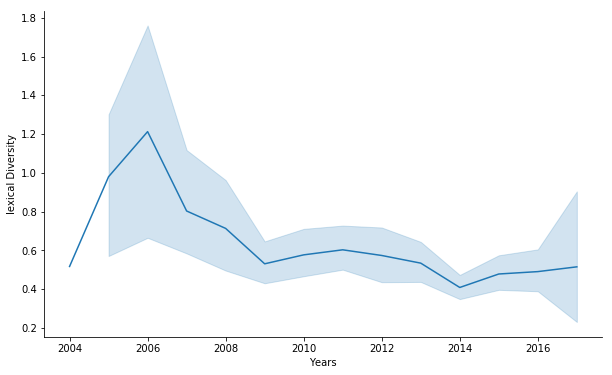

In [364]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Year',y='Lexical_Diversity',data=data)
plt.xlabel('Years')
plt.ylabel('lexical Diversity')
sns.despine()
plt.show()

From Above Plot it can be seen that Obama was bit more genral before he was elected as a president(before 2009) after 2009 the Diversiy of words in his speeches reduces and we can conclude those speeches are very focused one

## Word Cloud and Top Words 


 Initializing the Tokenizer

In [152]:
tokenizer = RegexpTokenizer("[a-zA-Z0-9]+")

Adding Some Additional Stop Words

In [187]:
extra_stop_words = ['ve', 'like', 'got', 'Cleveland', 'just', 
               'don', 'really', 'said', 'told', 'ok',
               'came', 'went', 'did', 'didn', 'good','will','it','that','s','t','m','u','re','going',
                   'could','would','might','must','need','sha','wo','y',"'s","'d","'ll","'t","'m","'re","'ve"]
stop_words = STOPWORDS.union(extra_stop_words)

Creating the Bar Graph for Yearly Most Used words in the Obama's Speeches.
Creating Word cloud for the top 100 words to see the More broader View

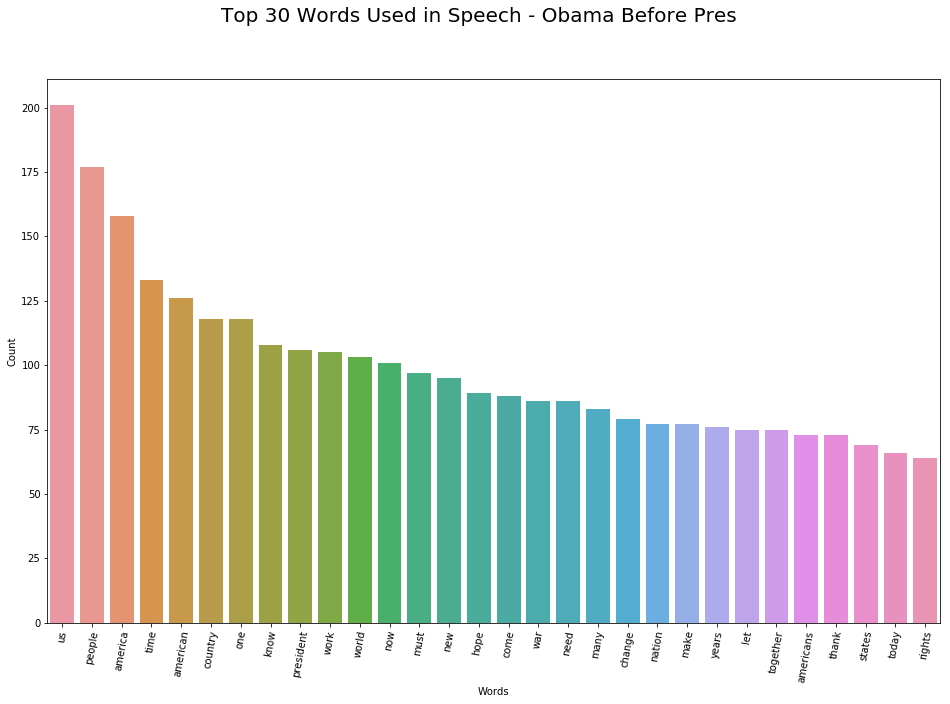

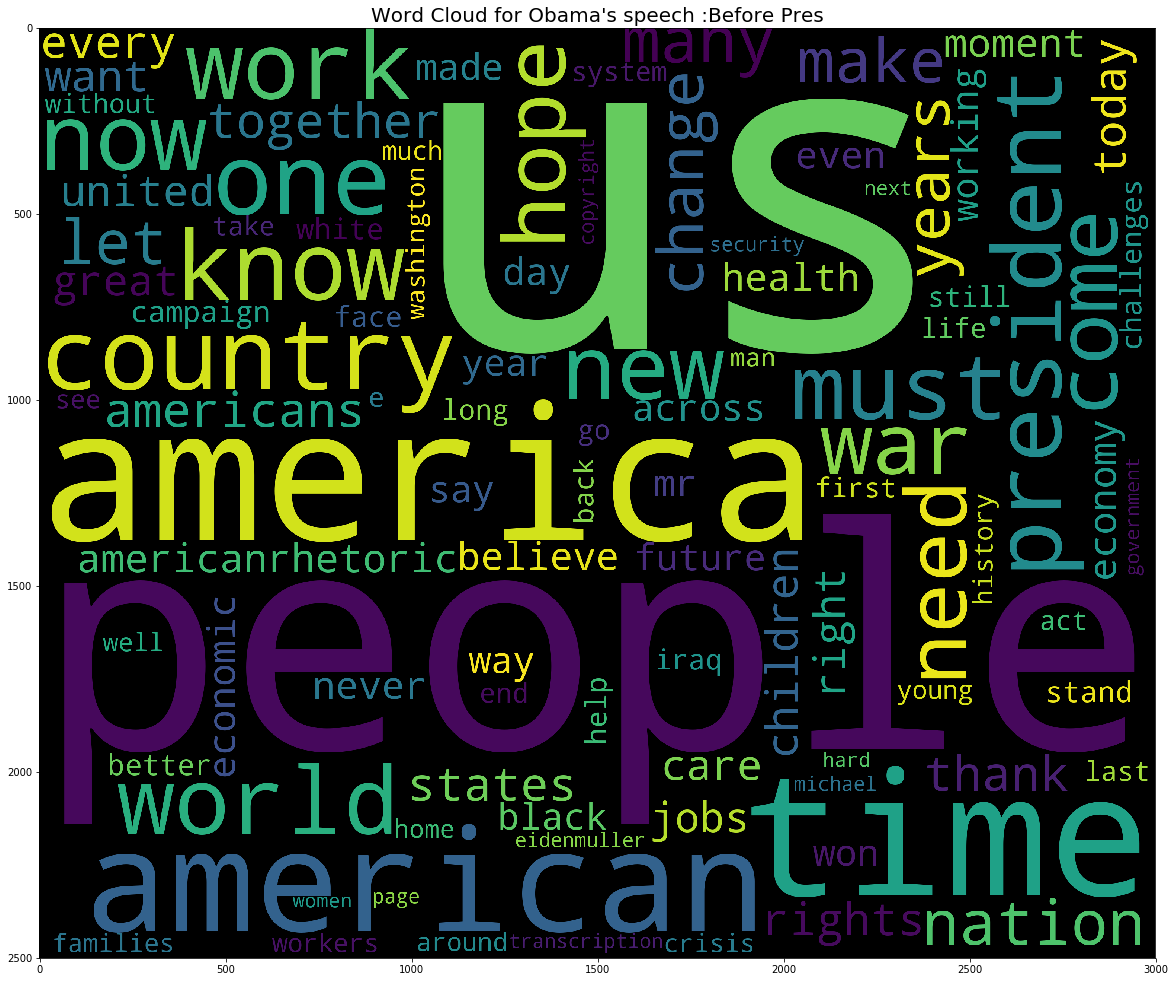

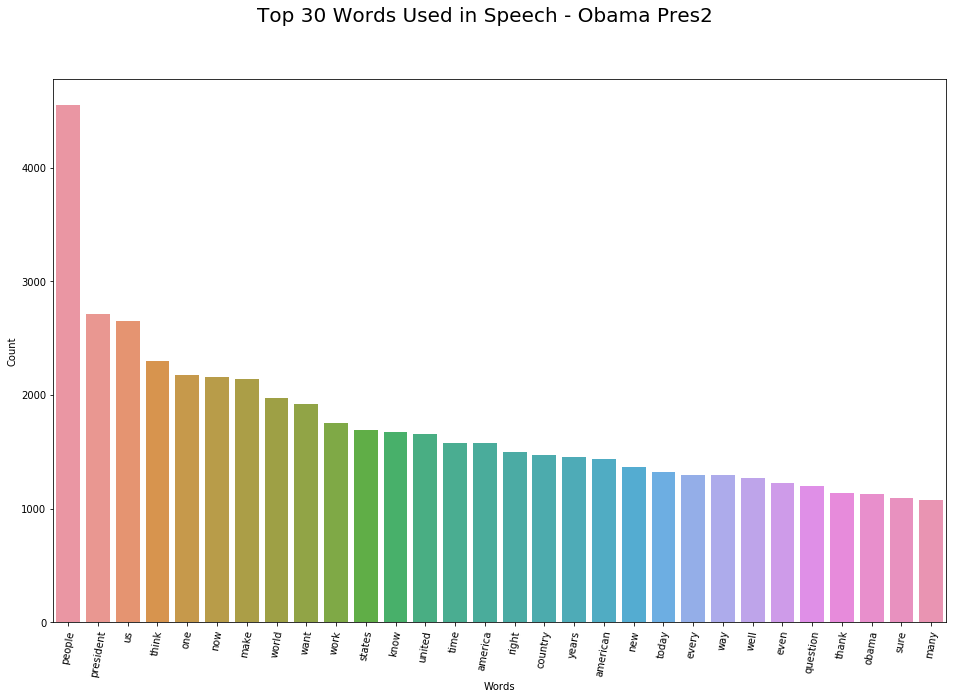

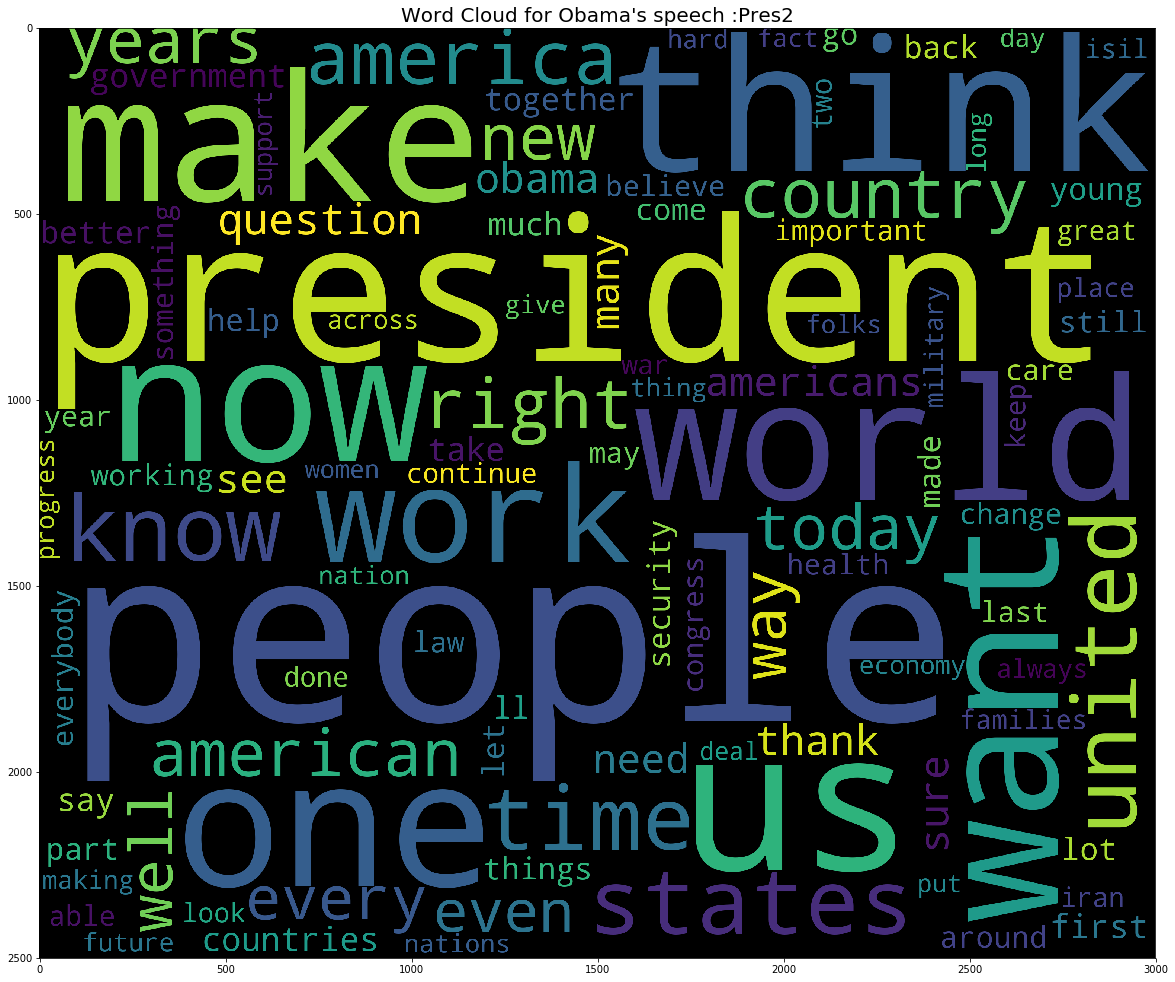

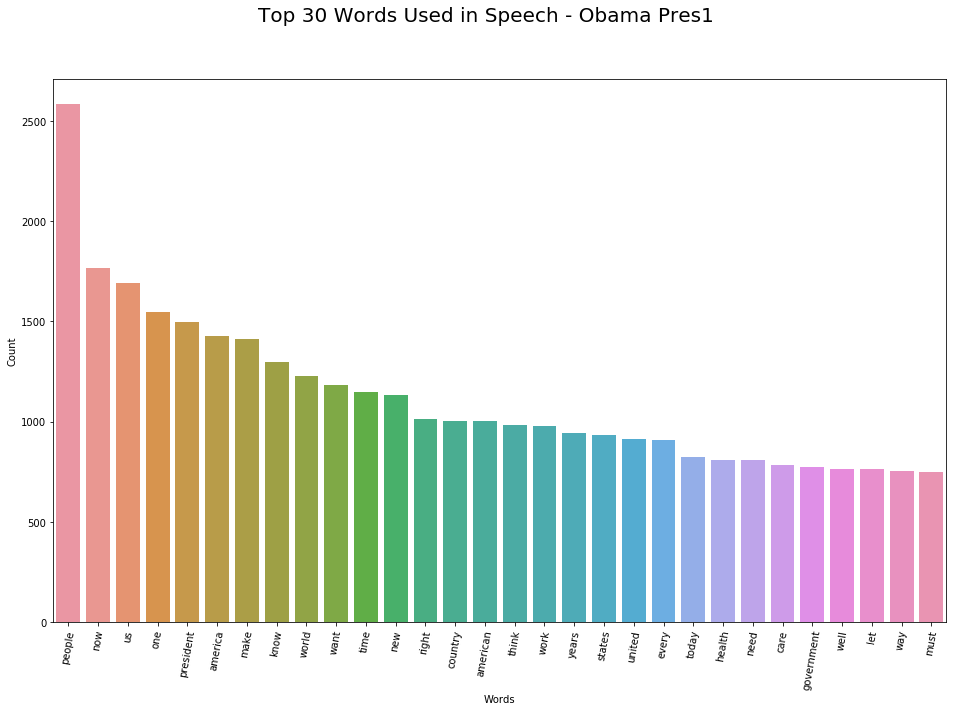

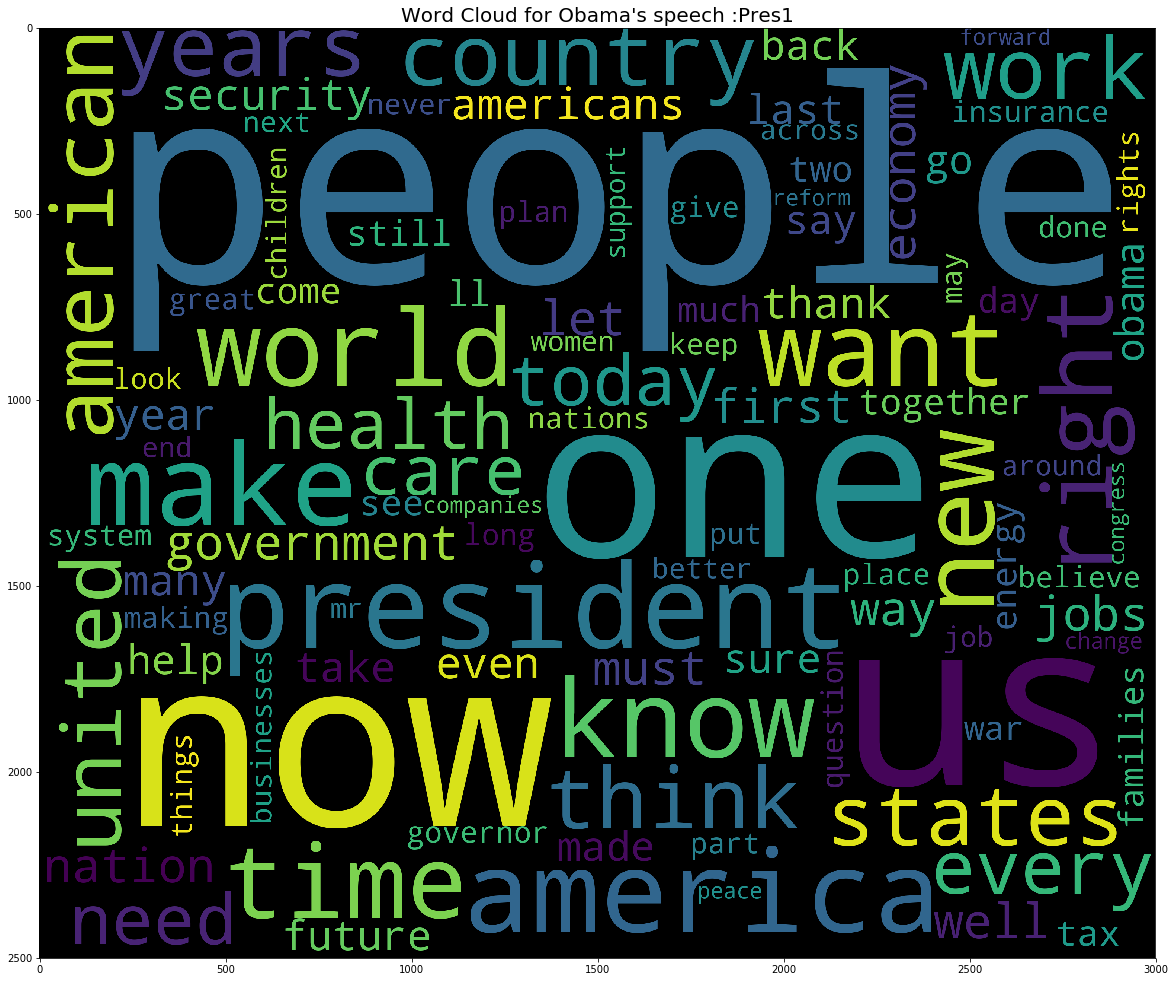

In [380]:
wc = WordCloud(max_words=100,
                      background_color='black',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500)
for Position in set(data.Pos):
    Position_df = data[data['Pos'] == Position]
#     s = ' '.join(Position_df['content'].tolist())
#     words = s.split(' ')
#     words = list(map(str.strip, words))
#     words = list(map(str.lower, words))
    tokens = [tokenizer.tokenize(x.lower()) 
          for x in Position_df['content']]
    
    filtered_tokens = [token for x in tokens for token in x if token not in stop_words]
    
    word_cloud = Counter(filtered_tokens)
    words_count = Counter(filtered_tokens).most_common(30)
#     words_count = words_count[:30]
    
    words_df = pd.DataFrame(words_count)
    
    words_df.rename(columns={0:"Words", 1:"Count"}, inplace=True)
    wc.generate_from_frequencies(word_cloud)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 10)
    fig.suptitle('Top 30 Words Used in Speech - Obama '+str(Position), fontsize=20)
    sns.barplot(x='Words', y='Count', data=words_df, ax=ax)
    plt.xticks(rotation=80)
    plt.show()
    plt.figure(figsize = (20,20))
    plt.title("Word Cloud for Obama's speech :"+str(Position),fontsize = 20)
    plt.imshow(wc)

From Above Plots and Word Clouds There are few insights can be made.

1. Before 2009 the period before he was POTUS, the top words used by Obama in his speeches Revolves Around US and People and Few mentions of War.

2. During his First Presidential Period that is from 2009 to early Jan 2013 which includes his second Election campaign period also, the most used word in his speeches is 'People' and that is used nearly 2 times than the second most used word that 'President'.

3. During his second and final Presidential Tenure that is from 2013 to Jan 2017, 'People' remains the Most Used word for his speeches.

4. As Most of the Sites have mentioned and as Most of us already know, During his Tenure Obama was Mostly inclined towards the People and ways to promote the human life, which may be one of the reason on why he earned Nobel Peace Prize

##### After Analyzing the Words used by Obama in his Speeches lets explore the Number of Sentences Used by Obama in his speeches for each year

In [309]:
sentences = [sent_tokenize(text) for text in data['content']]

In [310]:
data['Sentence_length'] = [len(sent) for sent in sentences]

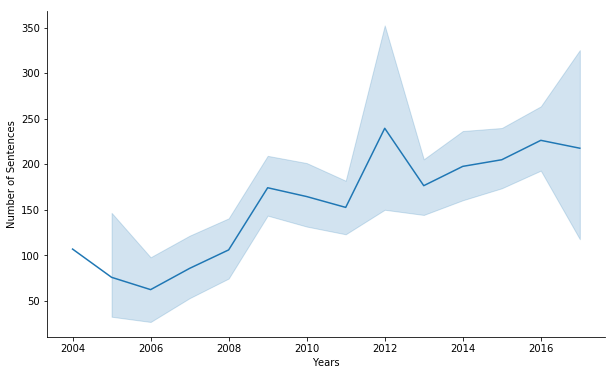

In [319]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Year',y='Sentence_length',data=data)
plt.xlabel('Years')
plt.ylabel('Number of Sentences')
sns.despine()
plt.show()

There are 2 peaks in the above graph, Some where near 2009 and somewhere 2012. Both are election or Campaign times. Which is Predictable, as the number of public speeches or announces sees a bump during these times.

## Topic Modelling

Topic modeling is an unsupervised machine learning technique that's capable of scanning a set of documents, detecting word and phrase patterns within them, and automatically clustering word groups and similar expressions that best characterize a set of documents

Lemmetization and LDA to build a model and using it to know the Distribution of Text among the defined Topics
We will Be Using PyLDAvis to export the topic modelling output in HTML format with LSI scores and clusters

### Lemmatization
Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma .

Creating Few functions that will be used in the process of Lemmetization

In [323]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 


In [324]:
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]

In [325]:
def clean_text(text):
    tokenized_text = word_tokenize(text.lower())
    cleaned_text = [t for t in tokenized_text if t not in STOPWORDS and re.match('[a-zA-Z\-][a-zA-Z\-]{2,}', t)]
    return lemmatize_sent(' '.join(cleaned_text))

Generating token data for each Speech and storing it in the DataFrame

In [381]:
wnl = WordNetLemmatizer()
data['tokens'] = data.content.apply(clean_text)

### Latent Dirichlet Allocation

In natural language processing, the latent Dirichlet allocation is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar

Building the Corpus.Dicionary from the Tokens generated in Lemmetization

In [340]:
# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(data.tokens)

dictionary.filter_extremes(no_below=3, no_above=.03)

# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in data.tokens]

In [388]:
# Build the LDA model
lda_model = models.LdaModel(corpus=corpus, 
                            random_state=123, 
                            iterations=500,
                            num_topics=20, 
                            id2word=dictionary)


In [389]:
print("LDA Model:")
print ("Number OF Topic : ",5)
for idx in range(5):
    # Print the first 5 most representative topics
    print("Topic #%s:" % idx, lda_model.print_topic(idx, 10))

LDA Model:
Number OF Topic :  5
Topic #0: 0.012*"detainee" + 0.010*"laos" + 0.008*"arne" + 0.007*"suu" + 0.006*"lao" + 0.006*"daw" + 0.005*"kyi" + 0.005*"aung" + 0.005*"outbreak" + 0.004*"fema"
Topic #1: 0.009*"warren" + 0.006*"gabby" + 0.006*"tennessee" + 0.004*"burundi" + 0.004*"addiction" + 0.004*"pell" + 0.004*"taylor" + 0.003*"christina" + 0.003*"martha" + 0.003*"artist"
Topic #2: 0.009*"marty" + 0.008*"vietnamese" + 0.006*"kenyan" + 0.006*"orleans" + 0.005*"alan" + 0.005*"czech" + 0.004*"egyptian" + 0.004*"illegally" + 0.004*"prague" + 0.004*"elie"
Topic #3: 0.023*"shimon" + 0.009*"kalamazoo" + 0.007*"scalia" + 0.007*"npt" + 0.005*"centrifuge" + 0.005*"campbell" + 0.005*"seoul" + 0.005*"peres" + 0.004*"nra" + 0.004*"christina"
Topic #4: 0.012*"shimon" + 0.008*"stevens" + 0.007*"elephant" + 0.007*"booker" + 0.006*"peres" + 0.004*"kenyan" + 0.004*"memphis" + 0.003*"nuclear-armed" + 0.003*"narrative" + 0.003*"conservation"


In [350]:
vis_data_lda = gensimvis.prepare(lda_model, corpus, dictionary)


C:\Users\91907\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [354]:
pyLDAvis.save_html(vis_data_lda,'C:/Users/91907/Praxis/text Analytics/lda_all.html')
# pyLDAvis.display(vis_data_lda)

After some 500 iterations we have received our 20 main topics

there is some overlapping in the topics but some well separated from the others

## Sentiment Analysis Using Vader

In [392]:
# Initializing the Analyser
analyzer = SentimentIntensityAnalyzer()

In [406]:
count = 0
neg = []
neu = []
pos = []
compound = []
for rev in data.content:
    neg.append(pd.Series(analyzer.polarity_scores(rev)).neg)
    neu.append(pd.Series(analyzer.polarity_scores(rev)).neu)
    pos.append(pd.Series(analyzer.polarity_scores(rev)).pos)
    compound.append(pd.Series(analyzer.polarity_scores(rev))['compound'])
    count = count+1
    
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Applying the Vader Sentiment Analysis on Obama's Speech and storing all the values of Negative,Positive,Neutral and Compound Scores

And Declaring the Speech as Positive if the compound score is > .05 

Negative if the compound score is < -.05 

Neutral otherwise

In [407]:
data['positive'] = pos
data['negative'] = neg
data['nuetral'] = neu
data['Compound'] = compound

In [409]:
def Sentiment(comp):
    if comp >= .05:
        return 'Positive'
    elif comp<= -.05:
        return 'Negative'
    else:
        return 'Neutral'

In [410]:
data['Sentiment'] = data.Compound.apply(Sentiment)

Checking only Negative Speeches

In [418]:
Neg_data = data[data.Sentiment!='Positive']

In [421]:
Neg_data[['heading','date']]

,heading,date
9,Barack Obama - Senate Speech Iraq Federalism A...,2007-03-13
10,Barack Obama - Iraq War After 4 Years.,2007-03-21
15,Barack Obama - More Perfect Union.,2008-03-18
32,Barack Obama - Lincoln Bicentennial.,2009-02-12
49,Barack Obama - DDay 65.,2009-06-05
202,Barack Obama - Gun Violence Exec Order 23.,2013-01-16
210,Barack Obama - Gun Violence Denver.,2013-04-03
215,Barack Obama - Senate Vote Background Check.,2013-04-17
225,Barack Obama - Drones and Terrorism National D...,2013-05-23
238,Barack Obama - Syria Speech to the Nation.,2013-09-10


In [419]:
Negative_Topics = list(Neg_data['heading'])

In [420]:
len(Negative_Topics)

29

Checking for the all the Speeches which are not Positive, just to check if the Sentiment Analysis is Correct or not

Out of 431 speech only 29 are Negative and all other are positive.

If we look out specifically for the Negative Speech topics, we can understand the Speech was either for Some War or For Some Violence activity or Terrorism, which would contain some sad or negative words hence the sentiment is coming to be negative.


## Conclusions

1. Over the time the Lexical Diversities in Obama's speeches has reduced and his speeches have gone more focused to one topic

2. During his Tenure as POTUS the most used word in his speeches is 'People'

3. The Number Of Sentences in his Speeches increase over the Years

4. Out 431 Speeches, 29 were about any War,Terrorism,Violence Activity or Sad Announcement. other than that all other speech are positive Sentiment Wise